In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

In [6]:
def get_epos(subID, part_epo, signaltype, condition, event_dict):
    """Load a set of specified epochs.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    condition: str
        Experimental condition. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict

    Returns
    -------
    mne.Epochs
        Array of selected epochs.
    """
    
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + part_epo +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, part_epo, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)


def get_sensordata(subID, part_epo, signaltype, conditions, event_dict):
    """Load a set of specified epochs for classification.
    
     Parameters
    ----------
    subID : str
        Subject identifier (eg, 'VME_S05')
    part_epo : str
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon'
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
    conditions: list
        List of experimental conditions. Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict

    Returns
    -------
    X_epos: Epochs
        Array of selected epochs, sorted by class (starting with class '0').
    y: list
        Sorted list of labels.
    times_n: array, 1d
        Times of the samples within the single epoch.
    """
    
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   part_epo=part_epo,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def decode(sub_list_str, conditions, event_dict, reps = 1, save_scores = True, part_epo = 'stimon', 
           signaltype='collapsed'):
    """Apply CSP and LDA to perform binary classification from (the power) of epoched data.
    
    
    
    
    Original code from: 
    https://mne.tools/stable/auto_examples/decoding/plot_decoding_csp_timefreq.html#
    sphx-glr-auto-examples-decoding-plot-decoding-csp-timefreq-py

    
    Parameters
    ----------
    sub_list_str : list of str
        List of subject identifiers (eg, 'VME_S05')
    conditions: list
        List of experimental conditions that shall be compared/decoded. 
        Combination of 'Ecc' and 'Load' (eg, 'LoadLow' or 'LoadLowEccS')
    event_dict: dict
        Dictionnary explaining the event codes. Normally this can be grabbed from config.event_dict
    reps: int 
        Number of repetions for the CV procedure.
    save_scores: bool, optional
        Shall the decoding scores be written to disk? (default is True).
    part_epo : str, optional
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon' (default is 'stimon').
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
                                                       (default is 'collapsed'.)

    Returns
    -------
    tf_scores_list: list
        list of 2d arrays (freq x time) with the decoding scores per subject
    centered_w_times: list
        list with the times around which the decoding windows were centered.
    """
    
    contrast_str = '_vs_'.join(conditions)
    scoring = 'accuracy'
    cv_folds = 5

    clf = make_pipeline(CSP(n_components=6, reg=None, log=True, norm_trace=False),
                        LinearDiscriminantAnalysis())
    
    # Classification & time-frequency parameters
    tmin = -0.5 # -config.times_dict['cue_dur']
    tmax =  2.5  # config.times_dict['stim_dur'] + config.times_dict['retention_dur']
    n_cycles = None  # how many complete cycles: used to define window size
    w_size = 0.5
    w_overlap = 0.5 # how much shall the windows overlap [value in [0,1]; 0: no overlap, 1: full overlap]
    min_freq = 6
    max_freq = 26
    n_freqs = 10  # how many frequency bins to use


    # Assemble list of frequency range tuples
    freqs = np.linspace(min_freq, max_freq, n_freqs + 1)  # assemble frequencies
    freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples# Setup list of seeds for the repetitions:
    
    # Setup list of seeds for the repetitions:
    np.random.seed(seed=42)
    rep_seeds = np.random.choice(range(10 * reps), reps)
    

    if ((n_cycles is not None) and (w_size is None)): 
        # Infer window spacing from the max freq and number of cycles to avoid gaps
        window_spacing = (n_cycles / np.max(freqs) / 2.)
        centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
    elif (((w_size is not None)) and (n_cycles is None)): 
        assert 0 <= float(w_overlap or -1) < 1, f'Invalid value for w_overlap: {w_overlap}'
        step_size = w_size * (1 - w_overlap)
        centered_w_times = np.arange(tmin + (w_size / 2.), tmax - (w_size / 2), step_size)
    else: 
        raise ValueError(f'Invalid combination of values for w_size and n_cylces. Exactly one must be None.')

    n_windows = len(centered_w_times)

    tf_scores_list = list()
    completed_subs = list()
    for subID in sub_list_str:
        part_epo = part_epo

        print(f'Running {subID}')

        X_epos, y, t = get_sensordata(subID, part_epo, signaltype, conditions, event_dict)
        # init scores
        tf_scores = np.zeros((n_freqs, n_windows))

        # Loop through each frequency range of interest
        for freq, (fmin, fmax) in enumerate(freq_ranges):

            # print(f'Freq. {freq} of {len(freq_ranges)}')

            if (w_size is None):
                # Infer window size based on the frequency being used (default behavuior is to use a fixed w_size)
                w_size = n_cycles / ((fmax + fmin) / 2.)  # in seconds

            # Apply band-pass filter to isolate the specified frequencies
            X_epos_filter = X_epos.copy().filter(fmin, fmax, n_jobs=-2, fir_design='firwin')

            # Roll covariance, csp and lda over time
            for t, w_time in enumerate(centered_w_times):

                # Center the min and max of the window
                w_tmin = w_time - w_size / 2.
                w_tmax = w_time + w_size / 2.

                # Crop data into time-window of interest
                X = X_epos_filter.copy().crop(w_tmin, w_tmax).get_data()
                
                tf_scores_tmp = np.zeros((reps, n_freqs, n_windows))
                for rep, rand_state in enumerate(rep_seeds):
                    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=rand_state)

                    # Save mean scores over folds for each frequency and time window for this repetition
                    tf_scores_tmp[rep, freq, t] = np.mean(cross_val_score(estimator=clf, X=X, y=y,
                                                                          scoring='accuracy', cv=cv,
                                                                          n_jobs=-2), axis=0)
                
                tf_scores = np.mean(tf_scores_tmp, axis=0)
                
        tf_scores_list.append(tf_scores)

        if save_scores:
            sub_scores_ = np.asarray(tf_scores_list)
            fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, 'scores')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, 'scores_per_sub.npy')
            np.save(fname, sub_scores_)
            np.save(fname[:-4] + '__times' + '.npy', centered_w_times)
            np.save(fname[:-4] + '__freqs' + '.npy', freq_ranges)
            del(fpath, fname)


        # save info:
        if save_scores:
            completed_subs.append(subID)
            info_dict = {'subs': completed_subs,
                         'tmin': tmin, 
                         'tmax': tmax, 
                         'n_cycles': n_cycles, 
                         'w_size': w_size,
                         'w_overlap': w_overlap,
                         'min_freq': min_freq, 
                         'max_freq': max_freq,
                         'n_freqs': n_freqs,
                         'cv_folds': cv_folds, 
                         'reps': reps,
                         'scoring': scoring}
            fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str)
            fname = op.join(fpath, 'info.json')
            with open(fname, 'w+') as outfile:  
                json.dump(info_dict, outfile)

    return tf_scores_list, centered_w_times


def load_scores_decod_tfr(conditions, part_epo='stimon', signaltype='collapsed'):
    """Load decoding results from disc.
    
    Parameters
    ----------
    conditions : list
        List of strings containing the classes of the classification. 
    part_epo : str, optional
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon' (default is 'stimon').
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
                                                       (default is 'collapsed'.)

    Returns
    -------
    results: ndarray 
        Array with decoding results (subjects x freqs x times)
    times: array, 1d
    freqs: array, 1d
    """
    
    contrast_str = '_vs_'.join(conditions)
    fpath = op.join(config.path_decod_tfr, part_epo, signaltype, contrast_str, 'scores')
    fname = op.join(fpath, 'scores_per_sub.npy')
    res = np.load(fname)
    times = np.load(fname[:-4] + '__times.npy')
    freqs = np.load(fname[:-4] + '__freqs.npy')
    return(res, times, freqs)


def plot_decod_image_tfr(scores, conditions, times, freqs, ax=None):
    """Plot a heatmap with decoding accuracy over time and frequency. 
    
    Parameters
    ----------
    scores : ndarray, 2d
        2d array with decoding results (freqs x timepoints)
    conditions : list
        List of strings containing the classes of the classification. 
    times: array, 1d
        Timepoints
    freqs: array, 1d
        Frequencies 
    ax: axis, optional
        Axis to plot into.

    Returns
    -------
    image
        AxisImage
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    dx = np.diff(times)[0] / 2
    dy = 0 #np.diff(freqs)[0] / 2
    extent = [times.min()-dx, times.max()+dx,
              freqs.min()-dy, freqs.max()+dy]             
    image = ax.imshow(scores, origin='lower', cmap='Greens', aspect='auto', extent=extent)
    ax.set_yticks([f for frange in freqs for f in frange])
    ax.set_ylabel('frequency (Hz)')
    return(image)


def plot_score_ts(scores_df, plt_dict, color, ax=None, n_boot=1000):
    """Plot the decoding scores as timeseries line plot.
    
    Parameters
    ----------
    scores_df : DataFrame 
        Data frame containing accuracies per time point in epoch. Long format. 
        Needed columns: 'time',
                        'score'
    plt_dict: dict
        Dict containing info relevant for plotting. 
        Entries needed: 't_stimon': relative time of stimulus onset
                        'xmin': minimal time to be plotted
                        'xmax': maximal time to be plotted
    color: str
        A single color string referred to by name, RGB or RGBA code,
        for instance ‘red’ or ‘#a98d19’.    
    ax: axis, optional
        Axis to plot into.
    n_boot: int
        Number of bootstrapping iterations for the CI.

    Returns
    -------
    image
        AxisImage
    
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    image = sns.lineplot(x='time', 
                 y='score', 
                 color = color,
                 data=scores_df, 
                 n_boot=n_boot,  
                 ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ytick_range[0], ymax=ytick_range[1], 
              linestyles='dashed')
    ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])
    return(image)


In [3]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = [8, 13]

scores, times, freqs = load_scores_decod_tfr(['LoadLow', 'LoadHigh'])

In [30]:
# translate freqs_of_interest to index:
indices = list()
if not isinstance(freqs_of_interest, list):
    freqs_of_interest = [freqs_of_interest]
for f_oi in freqs_of_interest:
    if isinstance(f_oi, tuple):
        for idx, freq in enumerate(freqs):
            if (((f_oi[0] >= freq[0]) and (f_oi[0] <= freq[-1])) or ((f_oi[0] <= freq[0]) and (f_oi[-1] >= freq[-1]))):
                indices.append(idx)
            if (((f_oi[1] > freq[0]) and (f_oi[1] <= freq[-1])) and (f_oi[0] <= freq[0])):
                indices.append(idx)
    else:
        for idx, freq in enumerate(freqs):
            if ((f_oi >= freq[0]) and (f_oi <= freq[1])):
                indices.append(idx)
indices = np.unique(indices)
print(indices )
freqs

[0 2]


array([[ 8., 10.],
       [10., 12.],
       [12., 14.]])

In [4]:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}



In [ ]:
import warnings
warnings.filterwarnings('ignore')

res_load = decode(sub_list_str, ['LoadLow', 'LoadHigh'], config.event_dict, reps=5)
res_ecc_sl = decode(sub_list_str, ['EccS', 'EccL'], config.event_dict, reps=5)
res_ecc_ml = decode(sub_list_str, ['EccM', 'EccL'], config.event_dict, reps=5)
res_ecc_sm = decode(sub_list_str, ['EccS', 'EccM'], config.event_dict, reps=5)
res_load_eccL = decode(sub_list_str, ['LoadLowEccL', 'LoadHighEccL'], config.event_dict, reps=5)
res_load_eccS = decode(sub_list_str, ['LoadLowEccS', 'LoadHighEccS'], config.event_dict, reps=5)
res_load_eccM = decode(sub_list_str, ['LoadLowEccM', 'LoadHighEccM'], config.event_dict, reps=5)

Running VME_S01


In [36]:
a, b = decode(sub_list_str, ['LoadLow', 'LoadHigh'], config.event_dict)

Running VME_S01
Running VME_S02
Running VME_S03
Running VME_S04
Running VME_S05
Running VME_S06
Running VME_S08
Running VME_S09
Running VME_S10
Running VME_S13
Running VME_S15
Running VME_S16
Running VME_S17
Running VME_S18
Running VME_S20
Running VME_S21
Running VME_S23
Running VME_S24
Running VME_S25
Running VME_S26
Running VME_S27


In [ ]:
res_load = decode(sub_list_str, ['LoadLow', 'LoadHigh'], config.event_dict)

<IPython.core.display.Javascript object>


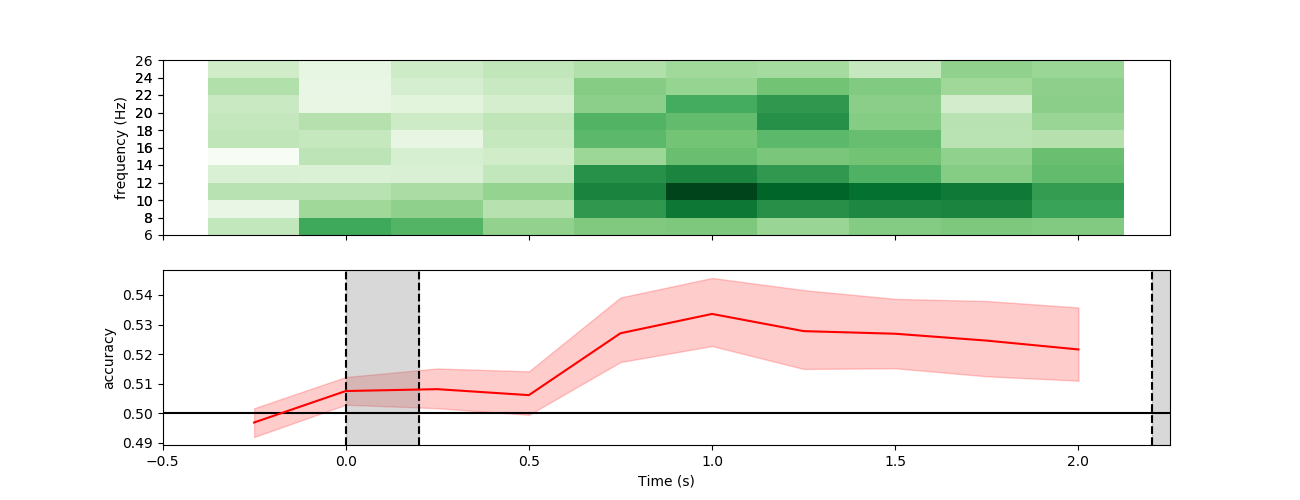

In [41]:
# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (8, 13)
# translate freqs_of_interest to index:
indices = list()
if not isinstance(freqs_of_interest, list):
    freqs_of_interest = [freqs_of_interest]
for f_oi in freqs_of_interest:
    if isinstance(f_oi, tuple):
        for idx, freq in enumerate(freqs):
            if (((f_oi[0] >= freq[0]) and (f_oi[0] <= freq[-1])) or ((f_oi[0] <= freq[0]) and (f_oi[-1] >= freq[-1]))):
                indices.append(idx)
            if (((f_oi[1] > freq[0]) and (f_oi[1] <= freq[-1])) and (f_oi[0] <= freq[0])):
                indices.append(idx)
    else:
        for idx, freq in enumerate(freqs):
            if ((f_oi >= freq[0]) and (f_oi <= freq[1])):
                indices.append(idx)
indices = np.unique(indices)

plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0]-0.25,
      'xmax': times[-1]+0.25}
plt_dict['stimon'] = pp


conditions = ['LoadLow', 'LoadHigh']

fig, ax = plt.subplots(2,1, sharex=True)
scores, times, freqs = load_scores_decod_tfr(conditions)
scores_avg = np.mean(scores, axis=0)
plot_decod_image_tfr(scores_avg, conditions, times, freqs, ax[0])

# if not isinstance(idx_freqs_oi, list): 
#     idx_freqs_oi = [idx_freqs_oi]
acc_df = pd.DataFrame(scores[:, indices, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'


plot_score_ts(acc_df_long, plt_dict['stimon'], color='red', ax=ax[1])


<IPython.core.display.Javascript object>


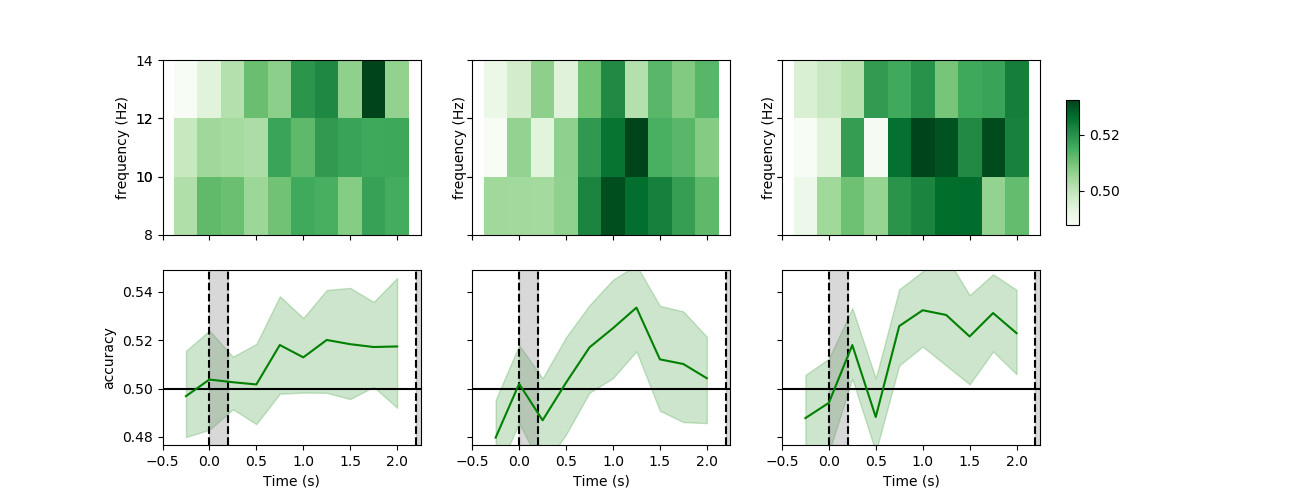

In [7]:
            
            


idx_freqs_oi = 1

plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0]-0.25,
      'xmax': times[-1]+0.25}
plt_dict['stimon'] = pp


fig, axx = plt.subplots(2,3, sharex=True, sharey='row')

for i, ecc in enumerate(['S', 'M', 'L']):
    conditions = ['LoadLowEcc' + ecc, 'LoadHighEcc' + ecc]

    scores, times, freqs = load_scores_decod_tfr(conditions)
    
    # Plot heatmap (freqs x times):
    scores_avg = np.mean(scores, axis=0) # average across subjects
    im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, axx[0,i])
    
    # Plot time series (averaged across frequencies of interest)
    if not isinstance(idx_freqs_oi, list): 
        idx_freqs_oi = [idx_freqs_oi]
    acc_df = pd.DataFrame(scores[:, idx_freqs_oi, :].mean(axis=1)) #average across freqs of interest
    acc_df.columns = times
    acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
    acc_df_long['decoding target'] = 'Load'
    plot_score_ts(acc_df_long, plt_dict['stimon'], 'green', axx[1,i], 1000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax)
    
plt.rcParams['figure.figsize'] = [13, 5]

(3, 10)

In [59]:
idx_freqs_oi = 1
acc_df = pd.DataFrame(a[:, [idx_freqs_oi], :].mean(axis=1))
acc_df.columns = times

acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'

In [86]:
times[-1]

2.0

AttributeError: 'numpy.ndarray' object has no attribute 'get_ylim'

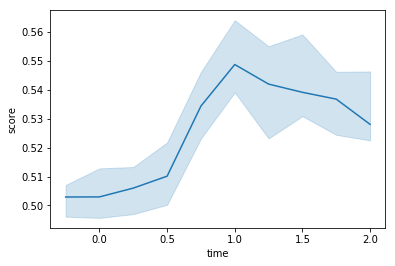

In [64]:
import seaborn as sns
sns.lineplot(x='time', 
             y='score', 
             data=acc_df_long, 
             n_boot=10)
ytick_range = ax.get_ylim()
ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
ax.set_ylabel('accuracy')
ax.set_xlabel('Time (s)')
ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
          ymin=ytick_range[0], ymax=ytick_range[1], 
          linestyles='dashed')
ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])

In [65]:

def plot_score_ts_per_factor(factor, data, plt_dict, ax, n_boot=1000):
    sns.lineplot(x='time', 
                 y='score', 
                 hue=factor, 
                 data=data, 
                 n_boot=n_boot, 
                 palette=config.colors, 
                 ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ytick_range[0], ymax=ytick_range[1], 
              linestyles='dashed')
    ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])


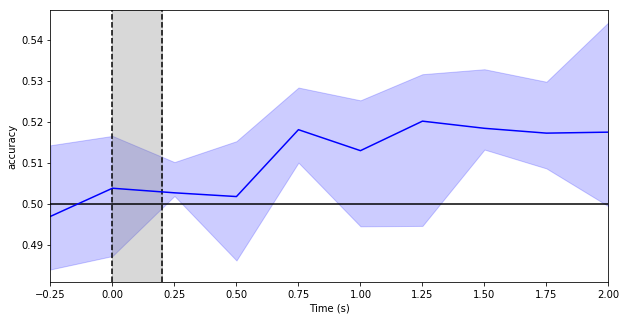

In [92]:
def plot_score_ts(data, plt_dict, color, ax, n_boot=1000):
    sns.lineplot(x='time', 
                 y='score', 
                 color = color,
                 data=data, 
                 n_boot=n_boot, 
                 palette=config.colors, 
                 ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ytick_range[0], ymax=ytick_range[1], 
              linestyles='dashed')
    ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])
    

plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp
fig, ax = plt.subplots(1,1)
plot_score_ts(acc_df_long, plt_dict['stimon'], 'blue', ax, n_boot=10)

In [73]:
plt_dict['t_stimon']

{}

In [87]:
acc_df_long

,time,score,decoding target
0,-0.25,0.469435,Load
1,-0.25,0.507845,Load
2,-0.25,0.493889,Load
3,-0.25,0.498295,Load
4,-0.25,0.405332,Load
5,-0.25,0.459289,Load
6,-0.25,0.556566,Load
7,-0.25,0.509408,Load
8,-0.25,0.519777,Load
9,-0.25,0.475817,Load
